In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.interpolate import make_interp_spline
import math

from PreProcess import PreProcess
from RNN_model import RNN_model

### Import the train data

Just to be used in this notebook

In [34]:
df_here = pd.read_csv('no1_train.csv')
df_here

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,341.330021,10.0,-4417.4
1,2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,330.114330,10.0,-4417.4
2,2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,323.877221,10.0,-4417.4
3,2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,296.438463,10.0,-4417.4
4,2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,269.097132,10.0,-4417.4
...,...,...,...,...,...,...,...,...,...,...
225083,2021-03-01 03:05:00,1942.486,191.881,20.1,106.431,0.0,2266.098,141.618915,0.0,-2252.9
225084,2021-03-01 03:10:00,1942.486,191.881,20.1,106.431,0.0,2266.098,129.043820,0.0,-2252.9
225085,2021-03-01 03:15:00,1942.486,191.881,20.1,106.431,0.0,2266.098,94.907548,0.0,-2252.9
225086,2021-03-01 03:20:00,1942.486,191.881,20.1,106.431,0.0,2266.098,102.589040,0.0,-2252.9


### Preprocess train and validation dataframes

In [35]:
model_forecast = PreProcess('no1_train.csv', 'no1_validation.csv')
steps_shift = 12 * 2 # two hours as a sequence length

In [36]:
g, x_val_batch, y_val_batch, x, y = model_forecast.main_preprocess(steps_shift, split=False, altered_forecasting=True)

C:\Users\hadho\Desktop\pro3\PreProcess.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.y[df.y > upper_value] = upper_value
C:\Users\hadho\Desktop\pro3\PreProcess.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.y[df.y < -lower_value] = -lower_value
C:\Users\hadho\Desktop\pro3\PreProcess.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.y[df.y > upper_value] = upper_value
C:\Users\hadho\Desktop\pro3\PreProcess.py:31

(225064, 24) (225064, 1)


Plotting the smoothed total flow sum

Text(0, 0.5, 'count')

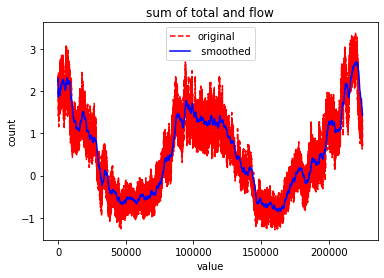

In [37]:
sum_total_flow = model_forecast.train_df['total']+model_forecast.train_df['flow']
sum_total_flow.plot(style = 'r--', label = 'original')
sum_total_flow.ewm(span = 3000).mean().plot(style = 'b', label = ' smoothed')

plt.legend()
plt.title("sum of total and flow")
plt.xlabel('value')
plt.ylabel('count')

Plotting some targets

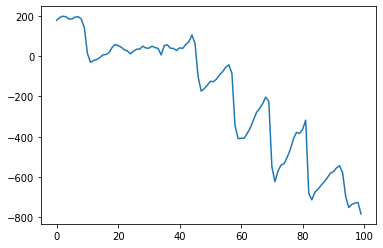

In [38]:
plt.plot(model_forecast.target_train_df['y'][:100])

Test the generator

In [39]:
gen = model_forecast.batch_generator(x, y, 256, steps_shift, x.shape[1], len(x))
x_batch, y_batch = next(gen)
batch = 0  
signal = 0 
print(x_batch.shape, y_batch.shape)

(256, 24, 24) (256, 1, 1)


### Scale the data and make the sequences

In [40]:
x_test_scaled, y_test_scaled = model_forecast.scale_data(model_forecast.test_df, model_forecast.target_test_df, steps_shift)
x_test_batch, y_test_batch = model_forecast.batch_generator_separated(x_test_scaled, y_test_scaled, steps_shift)

In [41]:
features_count = x_test_scaled.shape[1]

### Creat the RNN model

In [42]:
rnn_model = RNN_model((steps_shift, features_count), 1)
rnn_model.define_RNN_model()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 24)]          0         
                                                                 
 gru_2 (GRU)                 (None, 24, 512)           826368    
                                                                 
 gru_3 (GRU)                 (None, 32)                52416     
                                                                 
 output (Dense)              (None, 5)                 165       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 878,955
Trainable params: 878,955
Non-trainable params: 0
_________________________________________________________________


C:\Users\hadho\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [43]:
rnn_model.load_model('24_11_alt') # load a saved model

Fit the model

In [ ]:
history = rnn_model.fit_model(g, (x_val_batch, y_val_batch), rnn_model.define_callbacks())
print(history.history)

### Predict two hours in the future

In [55]:
y_predicted, y_true_forecast = model_forecast.predict_multi_steps(rnn_model, 12 * 2, x, y, steps_shift, 750, show=True)

y_true y_predicted
[0.34493051] [0.35577148]
y_true y_predicted
[0.33958526] [0.35844707]
y_true y_predicted
[0.33235871] [0.3580642]
y_true y_predicted
[0.35625286] [0.35836107]
y_true y_predicted
[0.42117218] [0.41335842]
y_true y_predicted
[0.45115448] [0.41335773]
y_true y_predicted
[0.44005344] [0.41335684]
y_true y_predicted
[0.42969473] [0.41335613]
y_true y_predicted
[0.42588798] [0.41335532]
y_true y_predicted
[0.41769239] [0.4133547]
y_true y_predicted
[0.41207941] [0.41335425]
y_true y_predicted
[0.40577745] [0.41335398]
y_true y_predicted
[0.40264556] [0.41335365]
y_true y_predicted
[0.39887588] [0.4133534]
y_true y_predicted
[0.39840372] [0.413353]
y_true y_predicted
[0.41759575] [0.4133588]
y_true y_predicted
[0.47565533] [0.41335204]
y_true y_predicted
[0.49977969] [0.5070373]
y_true y_predicted
[0.49421331] [0.50640863]
y_true y_predicted
[0.48704601] [0.46142808]
y_true y_predicted
[0.48439674] [0.46142262]
y_true y_predicted
[0.47965084] [0.46142614]
y_true y_predicte

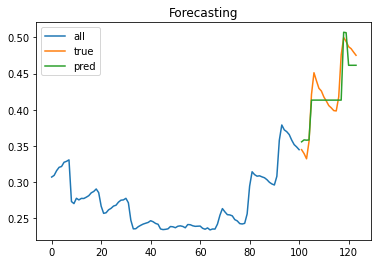

In [57]:
model_forecast.plot_forecast(y[650:774], y_true_forecast, y_predicted)

Rescale the data

In [58]:
y_rescaled = model_forecast.minmax_scaler_target.inverse_transform(y)
y_true_forecast_rescaled = model_forecast.minmax_scaler_target.inverse_transform(y_true_forecast)
y_predicted_rescaled = model_forecast.minmax_scaler_target.inverse_transform(y_predicted)

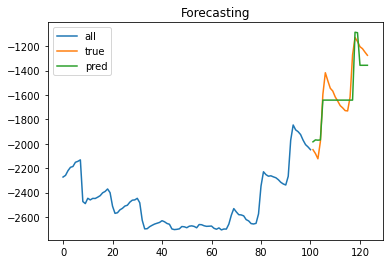

In [59]:
# model_forecast.plot_forecast(y_rescaled[24000:24124], y_true_forecast_rescaled, y_predicted_rescaled)
model_forecast.plot_forecast(y_rescaled[650:774], y_true_forecast_rescaled, y_predicted_rescaled)

### Evaluate validation data

In [69]:
rnn_model.evaluate_test(x_test_batch, y_test_batch)

878/878 [==============================] - 38s 42ms/step - loss: 0.0499


0.049872029572725296

### Prepare a test dataset

In [16]:
test_df = pd.read_csv('no1_validation.csv')

In [17]:
test_df, test_target = model_forecast.prepare_dataset(test_df, steps_shift, altered_forecasting=False)

C:\Users\hadho\Desktop\pro3\PreProcess.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.y[df.y > upper_value] = upper_value
C:\Users\hadho\Desktop\pro3\PreProcess.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.y[df.y < -lower_value] = -lower_value


In [18]:
x_test_scaled, y_test_scaled = model_forecast.scale_data(test_df, test_target, steps_shift, train=False)

In [19]:
x_val_batch, y_val_batch = model_forecast.batch_generator_separated(x_test_scaled, y_test_scaled, steps_shift)

In [20]:
rnn_model.evaluate_test(x_val_batch, y_val_batch)

878/878 [==============================] - 38s 41ms/step - loss: 0.0919


0.09186359494924545